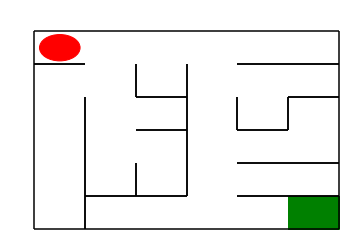

Maze of size (6, 6)
{'hit_wall': 10.0, 'destination': -144.0, 'default': 1}
action: r reward: 1
action: r reward: 1
action: r reward: 1
action: d reward: 1
action: d reward: 1
action: d reward: 1
action: d reward: 1
action: d reward: 1
action: r reward: 1
action: r reward: -144.0
success


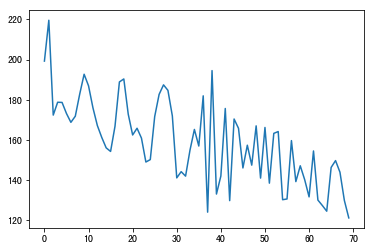

In [1]:
# 导入相关包 
import random
import numpy as np
import torch
from QRobot import QRobot
from ReplayDataSet import ReplayDataSet
from torch_py.MinDQNRobot import MinDQNRobot as TorchRobot # PyTorch版本
import matplotlib.pyplot as plt
from Maze import Maze
import time

class Robot(TorchRobot):
    def __init__(self, maze, epsilon=0.8, epsilon_decay=0.995):
        super(Robot, self).__init__(maze)
        
        maze.set_reward(reward={
            "hit_wall": 10.,
            "destination": -maze.maze_size ** 2 * 4.,
            "default": 1,
        })
        
        self.maze = maze
        # add epsilon-greedy init
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        
        self.memory.build_full_view(maze=maze)
        
        self.loss_list = self.train()
    
    def train_update(self):
        state = self.sense_state()
        
        # Epsilon-greedy exploration
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.valid_action)
        else:
            action = self._choose_action(state)
        
        reward = self.maze.move_robot(action)
        
        return action, reward
    
    def train(self):
        loss_list = []
        batch_size = len(self.memory)
        
        # start = time.time()
        while True:
            loss = self._learn(batch=batch_size)
            loss_list.append(loss)
            self.reset()
            
            for _ in range(self.maze.maze_size ** 2 - 1):
                a, r = self.test_update()
                if r == self.maze.reward["destination"]:
                    # print('Training time: {:.2f} s'.format(time.time() - start))
                    return loss_list
                    
            # change the value of epsilon
            self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)    
    
    def test_update(self):
        state = np.array(self.sense_state(), dtype=np.int16)
        state = torch.from_numpy(state).float().to(self.device)

        self.eval_model.eval()
        with torch.no_grad():
            q_value = self.eval_model(state).cpu().data.numpy()

        action = self.valid_action[np.argmin(q_value).item()]
        reward = self.maze.move_robot(action)
        return action, reward

maze = Maze(maze_size=6) 
print(maze)

robot = Robot(maze=maze)

print(robot.maze.reward) # 输出最小值选择策略的reward值

"""Test Robot"""
robot.reset()
for _ in range(maze.maze_size ** 2 - 1):
    a, r = robot.test_update()
    print("action:", a, "reward:", r)
    if r == maze.reward["destination"]:
        print("success")
        break
        
# 绘制损失曲线
loss_list = robot.loss_list
n = len(loss_list)
plt.plot(range(n), loss_list)